In [2]:
import pandas as pd
import numpy as np
import regex as re
from collections import Counter
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

In [32]:
df = pd.read_csv('cl3.csv')

In [33]:
df.head(20)

,text,rating
0,"Beautiful film, but so preachyLoveofLegacy21 J...",6
1,Clever and fun beginning turns into another le...,6
2,It was depressingcoxaneesa24 July 2023Warning:...,8
3,A Technicolor Dreamheatherhilgers24 July 2023W...,9
4,reasons FOR seeing it and 1 reason AGAINST.im...,7
5,Barbie Is A Weirdly Fun Movie!HabibieHakim1231...,8
6,Too heavy handedNatcat8722 July 2023Warning: S...,6
7,Fun and surprisingly touchingjpismyname19 July...,8
8,"High Highs, Low Lows.Lk199024 July 2023The fir...",6
9,Well this really did come as a surprise.Sleepi...,8


In [34]:
import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
print(stopwords)

{'can', "it's", 'that', 'itself', 'whom', 'further', 'on', 'here', "should've", 'ma', 'nor', 'has', 'if', 'he', 'does', 'couldn', 'those', 'but', "you'll", 'having', "you'd", 'no', 'just', 'off', 'didn', 'isn', 'as', 'both', 'about', 'very', "shouldn't", 'have', "hadn't", "doesn't", 'hadn', 'between', 'yours', 'up', 'be', 'over', 's', 'my', 'with', 'until', 'won', 'or', 'is', "won't", 'd', 'once', 'our', 'o', "wouldn't", 'herself', 'needn', 'wouldn', 'was', 'haven', 'me', 'again', 'which', 'y', "needn't", "hasn't", 'the', 'ourselves', 'against', 'll', 'out', 'a', 'then', 'at', 'his', 'more', 'some', "mustn't", 'm', "mightn't", 'we', 'to', 're', "shan't", 'am', 'below', 'when', 'each', "that'll", 'only', 'doing', 'shouldn', 'because', "you're", 'are', "didn't", 'she', 'been', 'before', 'than', 'from', 'weren', 'what', 'during', 'now', 'mustn', "you've", "she's", "wasn't", 'wasn', 've', 'same', 'did', 'ours', 'in', 'them', 'who', 'above', 'of', 'themselves', 'myself', 'this', 'will', 'un

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


In [35]:
def tokenize(text):
    return re.findall(r'[\w-]*[a-z|A-Z][\w-]*', text)

In [36]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]
pipeline = [str.lower, tokenize, remove_stop]

In [38]:
def prepare(text, pipeline):
    tokens = text
    for fun in pipeline:tokens = fun(tokens)
    return tokens
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)

In [39]:
counter = Counter()
df['tokens'].map(counter.update)
freq_df = pd.DataFrame.from_dict(counter, orient='index',columns=['freq'])
freq_df = freq_df.query('freq >= 1')
freq_df.index.name = 'token'
freq_df = freq_df.sort_values('freq', ascending=False)
freq_df.head(10)

,freq
token,
movie,1899
barbie,1718
helpful,1595
film,940
found,839
review,826
vote,801
july,799
sign,798


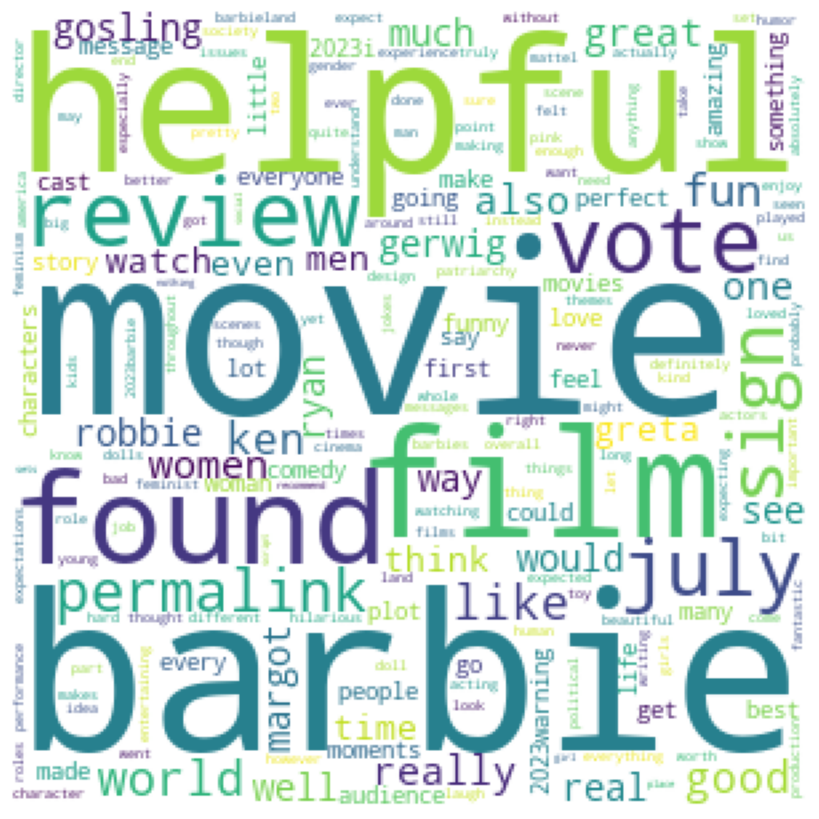

In [40]:
wc = WordCloud(background_color='white', width = 300, height=300, margin=2)
wc.fit_words(freq_df['freq'].to_dict() )
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [41]:
def compute_idf(df, column='tokens', preprocess=None, min_df=1):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))
    counter = Counter()
    df[column].map(update)# create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df
idf_df = compute_idf(df)

In [42]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']
freq_df.head()

,freq,tfidf
token,,
movie,1899,943.272263
barbie,1718,1028.686468
helpful,1595,159.500000
film,940,1044.315330
found,839,83.900000


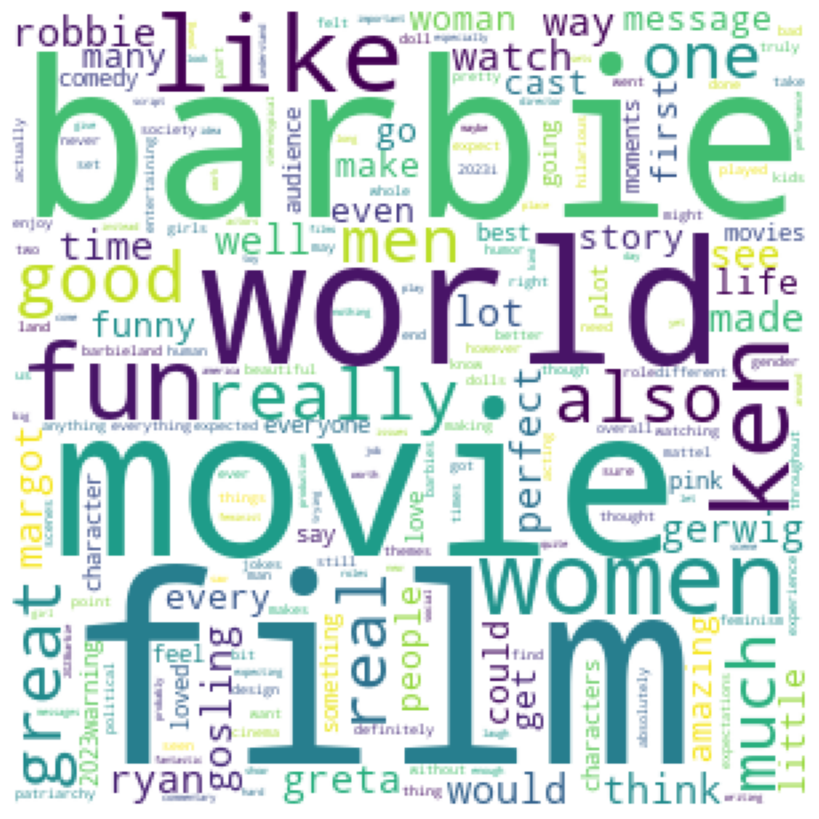

In [43]:
wc = WordCloud(background_color='white', width = 300, height=300,margin=2)
wc.fit_words(freq_df['tfidf'].to_dict() )
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# 1970

In [44]:
df['num_tokens'] = df['tokens'].map(len)
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [45]:
def count_keywords_by(df, by, keywords, column='tokens'):
    df = df.reset_index(drop=True) # if the supplied dataframe has gaps inthe index
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix,columns=keywords)
    freq_df[by] = df[by] # copy the grouping column(s)
    return freq_df.groupby(by=by).sum().sort_values(by)

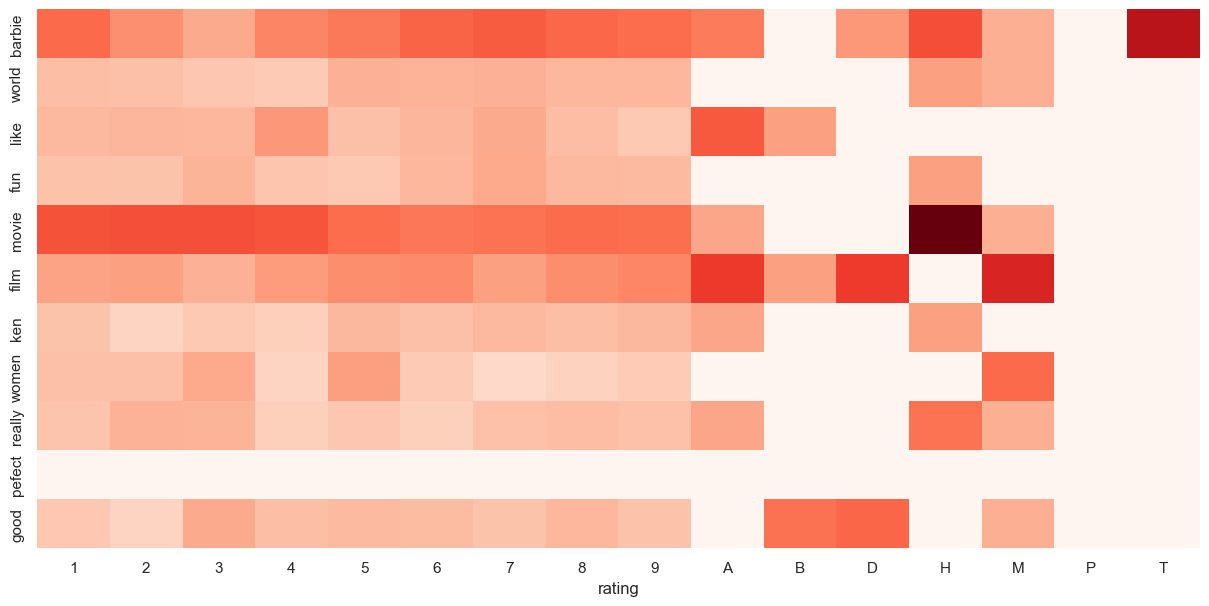

In [48]:
keywords = ['barbie','world','like','fun','movie','film','ken','women','really','pefect','good']
freq_df = count_keywords_by(df, by='rating', keywords=keywords)
freq_df = freq_df.div(df.groupby('rating')['num_tokens'].sum(), axis=0)
freq_df = freq_df.apply(np.sqrt)
# Plotting the heatmap
plt.figure(figsize=(15, 7))
sns.set(font_scale=1)
sns.heatmap(data=freq_df.T,xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")
sns.set(font_scale=1)